<a href="https://colab.research.google.com/github/Bo2mimi/Dacon/blob/main/LV1_%EB%94%B0%EB%A6%89%EC%9D%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [13]:
import pandas as pd
import math
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Data

In [2]:
# 데이터 다운로드 링크로 데이터를 코랩에 불러옵니다.

!wget 'https://bit.ly/3gLj0Q6'

import zipfile
with zipfile.ZipFile('3gLj0Q6', 'r') as existing_zip:
    existing_zip.extractall('data')

--2022-07-24 10:18:16--  https://bit.ly/3gLj0Q6
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E [following]
--2022-07-24 10:18:16--  https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E
Resolving drive.google.com (drive.google.com)... 173.194.218.139, 173.194.218.113, 173.194.218.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dt9n2n62m7iqrqcfvlqr5hhqkfnam93n/1658657850000/17946651057176172524/*/1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E?e=download&uuid=17629079-0387-4fc0-b4b6-6c15a0f7205f [following]
--2022-07-24 10:18:17--  https://doc-0c-10-doc

In [2]:
train = pd.read_csv('data/train.csv') 
test = pd.read_csv('data/test.csv')

# 3. EDA

In [3]:
print('train set: ', train.shape)
print('test set: ', test.shape)

train.head()

train set:  (1459, 11)
test set:  (715, 10)


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


### column 해설
- id : 날짜와 시간별 id
- hour_bef_temperature : 1시간 전 기온
- hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
- hour_bef_windspeed : 1시간 전 풍속(평균)
- hour_bef_humidity : 1시간 전 습도
- hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- hour_bef_ozone : 1시간 전 오존
- hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count : 시간에 따른 따릉이 대여 수

In [4]:
print('train set null 데이터 수: \n', train.isnull().sum())
train = train.dropna()
print('null 데이터 제거 후 데이터 수: ', train.shape)
print('train set null 데이터 재확인: ', train.isnull().sum().sum())

train set null 데이터 수: 
 id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64
null 데이터 제거 후 데이터 수:  (1328, 11)
train set null 데이터 재확인:  0


In [5]:
print('test set null 데이터 수: \n', test.isnull().sum())
test = test.fillna(0)
print('null 데이터 0으로 채운 후 데이터 수: ', test.shape)
print('test set null 데이터 재확인: ', test.isnull().sum().sum())

test set null 데이터 수: 
 id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64
null 데이터 0으로 채운 후 데이터 수:  (715, 10)
test set null 데이터 재확인:  0


# 4. Load Model

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

model_dict = {'DT':DecisionTreeRegressor(),
             'RF':RandomForestRegressor(),
             'LGB':lgb.LGBMRegressor(),
             'XGB':xgb.XGBRegressor(),
             'KNN':KNeighborsRegressor()}

# 5. Model

In [7]:
k_fold = KFold(n_splits=5, shuffle= True, random_state=10)
X_train = train.drop(['count'], axis=1)
Y_train = train['count']

In [8]:
from sklearn.model_selection import cross_val_score
score = {}

for model_name in model_dict.keys():
    
    model = model_dict[model_name]
    
    score[model_name] = np.mean(cross_val_score(model, X_train, Y_train, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = k_fold))
    
    print(f'{model_name} 평가 완료')

DT 평가 완료
RF 평가 완료
LGB 평가 완료
XGB 평가 완료
KNN 평가 완료


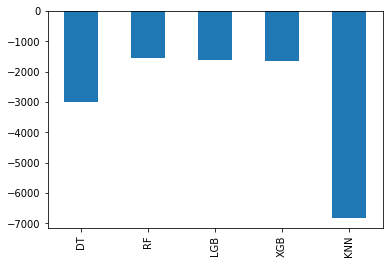

In [9]:
pd.Series(score).plot(kind = 'bar')

In [ ]:
pred = model.predict(test)

# 6. Visualization

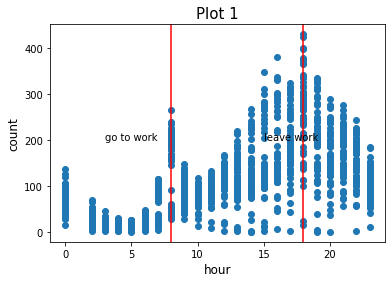

In [17]:
plt.title('Plot 1', fontsize = 15)
plt.plot('hour', 'count', 'o', data = train)
plt.xlabel('hour', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.axvline(8, color = 'red')
plt.axvline(x=18,color='r')
plt.text(3, 200, 'go to work', fontsize = 10);
plt.text(15, 200, 'leave work', fontsize = 10);
plt.show();

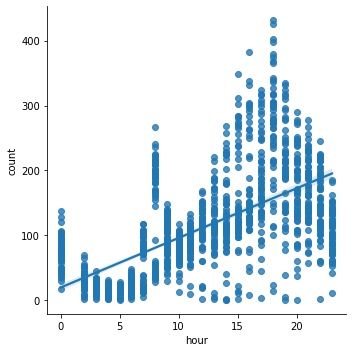

In [14]:
sns.lmplot(x = 'hour', y = 'count', data = train)

# 5. Results


In [17]:
submission = pd.read_csv('data/submission.csv')
submission['count'] = pred
submission.to_csv('sub.csv',index=False)